In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("../incl/")


(50, 4, 50)


<IPython.core.display.Javascript object>


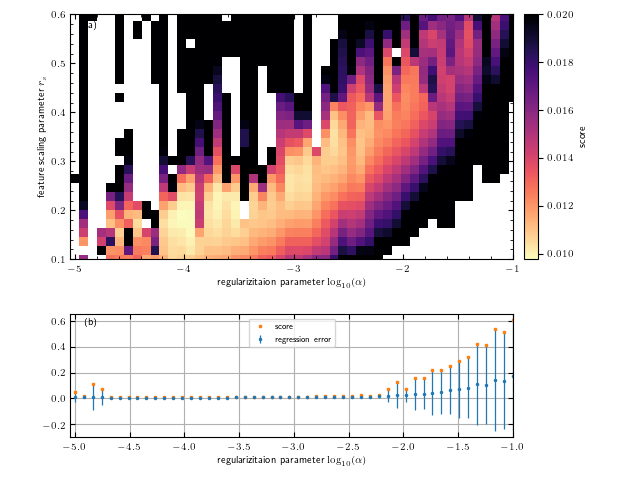

In [22]:
%matplotlib notebook


import os
path = '/home/agluedge/Preprints/ELPH/data/run8_ELM_features_optimization/data/'

filenames = []
# r=root, d=directories, f = filenames
for r, d, f in os.walk(path):
    for file in f:
        if 'rs_' in file:
            filenames.append(os.path.join(r, file))

#for f in filenames:
    #print(f)

from natsort import realsorted
filenames = realsorted(filenames)


# ##print filenames
# for f in filenames:
#     print(f)
# nYdata = len(filenames)
# print(nYdata)
    
  
scans = [] # that data goes into this list
for fn in filenames:
  scans.append(np.loadtxt(fn)) #load linescan an append to the list of linescans - each linescan is matrix

scans = np.asarray(scans) #create numpy ndarray from list -- contains all the data -- format [number of files, sweep steps, data column]
print (scans.shape)


std = scans[:,0,:]
std_std = scans[:,1,:]

scores = std + std_std


VMAX = 0.02

###########
###########

ny,nx = scores.shape

xmin = -5
xmax = -1

ymin = 0.1
ymax = 1.0

y = np.linspace(ymin,ymax,ny)
x = np.linspace(xmin,xmax,nx)

dx = (xmax-xmin)/(nx-1)/2
dy = (ymax-ymin)/(ny-1)/2

extent = [xmin-dx,xmax+dx,ymin-dy,ymax+dy]


scrs = scores.copy()
for k in range(scrs.size):
    if np.isnan(scrs.flat[k]):
        scrs.flat[k] = 1


yminAr = np.amin(scrs, axis=1)
xminAr = np.amin(scrs, axis=0)

yminAr = np.ma.masked_greater(yminAr, VMAX*2)
xminAr = np.ma.masked_greater(xminAr, VMAX*2)

scores = np.ma.masked_greater(scores, VMAX*2)


xlim_min = xmin-dx
xlim_max = -1

ylim_min = 0.1
ylim_max = 0.6 #ymax + dy



####################################################
####################################################
####################################################

from matplotlib import rc
rc('text', usetex=True)

from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib import colors

fs = 7
# fig = plt.figure(figsize=(3.5,3.5))
plt.rcParams.update({'font.size': fs})
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1,0.03], height_ratios=[2,1])



####################################################
####################################################
####################################################




ax00 = plt.subplot(gs[0,0])

im = plt.imshow(scores, origin='lower', interpolation='none', aspect='auto', vmax=VMAX, extent=extent, cmap='magma_r')

# im = plt.imshow(scores, origin='lower', interpolation='none', aspect='auto', norm=colors.LogNorm(vmax=VMAX), extent=extent, cmap='magma_r')

# plt.colorbar()

    
plt.xlabel(r'regularizitaion parameter $\log_{10}(\alpha)$')
plt.ylabel(r'feature scaling parameter $r_s$')

plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)


ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
# ax00.yaxis.set_major_formatter(ticker.NullFormatter())
# ax00.yaxis.set_minor_formatter(ticker.NullFormatter())


plt.text(0.03, 0.97,r'(a)', color='k', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)

# plt.text(0.25, 0.75,'regression\n diverged', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)

axCB = plt.subplot(gs[0,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"score")
####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[1,0])


plt.grid(0.5)

plt.errorbar(x, std[0], yerr=std_std[0], ls='none', lw=0.9, marker='o', ms=1.5,  label='regression error')

plt.plot(x, std[0]+std_std[0], ls='none', lw=0.7, marker='s',  ms = 1.5, label='score')

plt.legend(fontsize=fs-1, loc='upper center')

plt.xlim(xlim_min, xlim_max)

plt.xlabel(r'regularizitaion parameter $\log_{10}(\alpha)$')
# plt.ylabel(r'regularizitaion parameter $\log_{10}(\alpha)$')



    
ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

# ax00.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
# ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
# # # ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# # # ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

# ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
# ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.002))
# # ax00.yaxis.set_major_formatter(ticker.NullFormatter())
# # ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(b)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


####################################################
####################################################
####################################################

plt.tight_layout()

plt.subplots_adjust(left=0.11, bottom=0.09, right=0.84, top=0.97, wspace=0.05, hspace=0.3)

plt.savefig('/home/agluedge/Preprints/ELPH/figs/ELM_opt.pdf', dpi=600)
plt.show()